# Investigate wind

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
#import histlib.diagnosis as diag
import histlib.erastar as eras

from dask.distributed import wait
from histlib.cstes import labels, zarr_dir, matchup_dir

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Time's estimation 

11 load t =< 2min 
1 obs load pour 25 t =< 1/5 min environ  -> temps = 1/5 *taillechunkobs * nbchunk/nbprocess = 1/4 * totalobs/nbcores  
taillechunkobs = nb_obs/nb_cores/n n entier naturel

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    from dask import config
    config.set({"distributed.comm.timeouts.connect": "200s"})
    cluster = PBSCluster(cores=20, processes=20, walltime='01:00:00')
    #cluster = PBSCluster(cores=20, processes=20, walltime='02:00:00')#8
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.215:8787/status,
Dashboard: http://10.148.0.215:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.215:51830,Workers: 0
Dashboard: http://10.148.0.215:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [11]:
np.sign(7)

1

_____________________
# Map of taux, tauy

In [18]:
DS = []
for l in labels:
    # data 
    dsd = xr.open_zarr(os.path.join(zarr_dir, f'{l}.zarr')).reset_coords(['drifter_lon', 'drifter_lat','drifter_time', 'drifter_x', 'drifter_y', 'lon', 'lat', 'time'])
    dsd = dsd.where(dsd.alti___distance<2e5, drop=True).chunk({'obs':500, 'site_obs':-1})[['lon', 'lat',"f","box_theta_lon","box_theta_lat","drifter_theta_lon","drifter_theta_lat"]]
    
    # Erastar
    zarr = os.path.join(zarr_dir+'_ok', "erastar/erastar_"+l+".zarr")
    dse = xr.open_dataset(zarr)
    
    # Compute back 
    var0 = ['es_drifter_matchup_taue', 'es_drifter_matchup_taun', 'es_alti_matchup_taue', 'es_alti_matchup_taun', 'lon','lat', 'f']
    var1 = ['es_cstrio_z0_drifter_wd_e', 'es_cstrio_z0_drifter_wd_n','es_cstrio_z0_alti_wd_e', 'es_cstrio_z0_alti_wd_n',
           'es_cstrio_z15_drifter_wd_e', 'es_cstrio_z15_drifter_wd_n','es_cstrio_z15_alti_wd_e', 'es_cstrio_z15_alti_wd_n']
    ds_ = xr.merge([dse, dsd]).chunk({'obs':500, 'site_obs':-1})
    from histlib.stress_to_windterm import list_wd_srce_suffix, list_func,list_func_suffix, cst_rio_z0, cst_rio_z15, compute_wd_from_stress
    _ds =compute_wd_from_stress(ds_, list_wd_srce_suffix, list_func, list_func_suffix, True)[var1]
    
    dsf = xr.merge([ds_[var0], _ds]).persist()
    DS.append(dsf)
    print(l)

gps_Jason-3_2020
argos_Jason-3_2020
gps_SARAL_2020
argos_SARAL_2020
gps_Cryosat-2_2020
argos_Cryosat-2_2020
gps_Sentinel-3_A_2020
argos_Sentinel-3_A_2020
gps_Sentinel-3_B_2020
argos_Sentinel-3_B_2020
gps_Jason-3_2019
argos_Jason-3_2019
gps_SARAL_2019
argos_SARAL_2019
gps_Cryosat-2_2019
argos_Cryosat-2_2019
gps_Sentinel-3_A_2019
argos_Sentinel-3_A_2019
gps_Sentinel-3_B_2019
argos_Sentinel-3_B_2019
gps_Jason-3_2018
argos_Jason-3_2018
gps_SARAL_2018
argos_SARAL_2018
gps_Cryosat-2_2018
argos_Cryosat-2_2018
gps_Sentinel-3_A_2018
argos_Sentinel-3_A_2018
gps_Sentinel-3_B_2018
argos_Sentinel-3_B_2018
gps_Jason-3_2017
argos_Jason-3_2017
gps_Jason-2_2017
argos_Jason-2_2017
gps_SARAL_2017
argos_SARAL_2017
gps_Cryosat-2_2017
argos_Cryosat-2_2017
gps_Sentinel-3_A_2017
argos_Sentinel-3_A_2017
gps_Jason-3_2016
argos_Jason-3_2016
gps_Jason-2_2016
argos_Jason-2_2016
gps_SARAL_2016
argos_SARAL_2016
gps_Cryosat-2_2016
argos_Cryosat-2_2016
gps_Sentinel-3_A_2016
argos_Sentinel-3_A_2016
gps_Jason-2_2015
arg

In [19]:
ds = xr.concat(DS, dim='obs').chunk({'obs':500})

In [21]:
ds['obs']=np.arange(0,ds.dims['obs'])

In [24]:
ds['un_15_ekman'] = -ds.es_cstrio_z15_alti_wd_e/ds.f
ds['ue_15_ekman'] = ds.es_cstrio_z15_alti_wd_n/ds.f

In [31]:
ds.to_zarr(os.path.join(zarr_dir+'_ok', 'test_wind.zarr'))

________________
# MAPS

In [28]:
df = ds.to_dask_dataframe()
dl = 5
df["latbin"] = (df.lat // dl) * dl
df["lonbin"] = (df.lon // dl) * dl

dd = df.groupby(["latbin", "lonbin"]).mean()

In [30]:
dsl = dd.compute().to_xarray()


KeyboardInterrupt



In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
dsl.plot.quiver(x='lonbin', y='latbin', ax=ax,u = 'es_alti_matchup_taue', v='es_alti_matchup_taun', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
ax.set_title('Wind Stress from ERASTAR')

Text(0.5, 1.0, 'Wind Stress from ERASTAR')

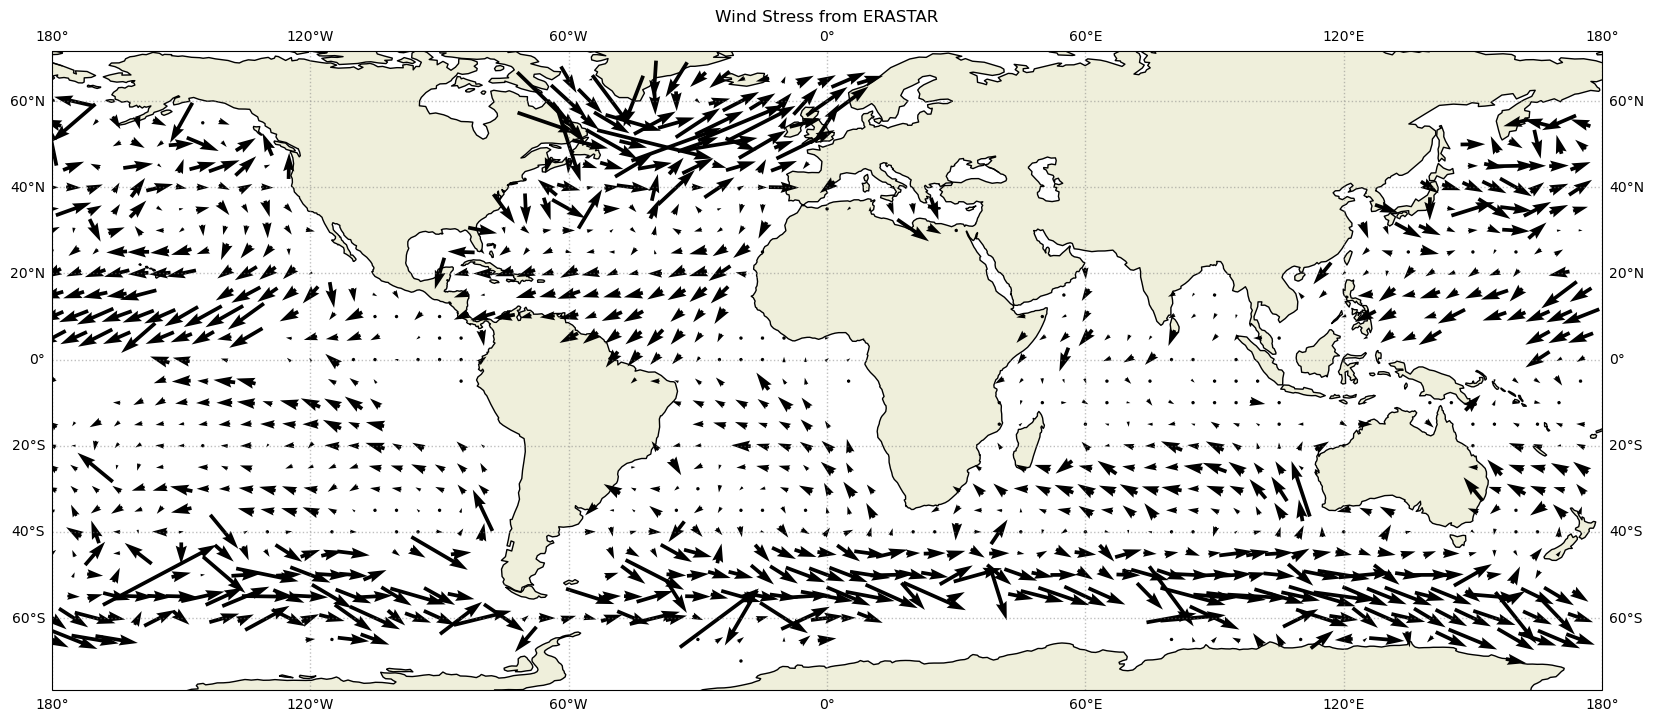

In [44]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
dsl.plot.quiver(x='lonbin', y='latbin', ax=ax,u = 'es_alti_matchup_taue', v='es_alti_matchup_taun', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
ax.set_title('Wind Stress from ERASTAR')

Text(0.5, 1.0, 'Zonal Ekman velocities from ERASTAR + Rio 2014 ->  à comparer avec Figure 9 de Rio 2011 par example')

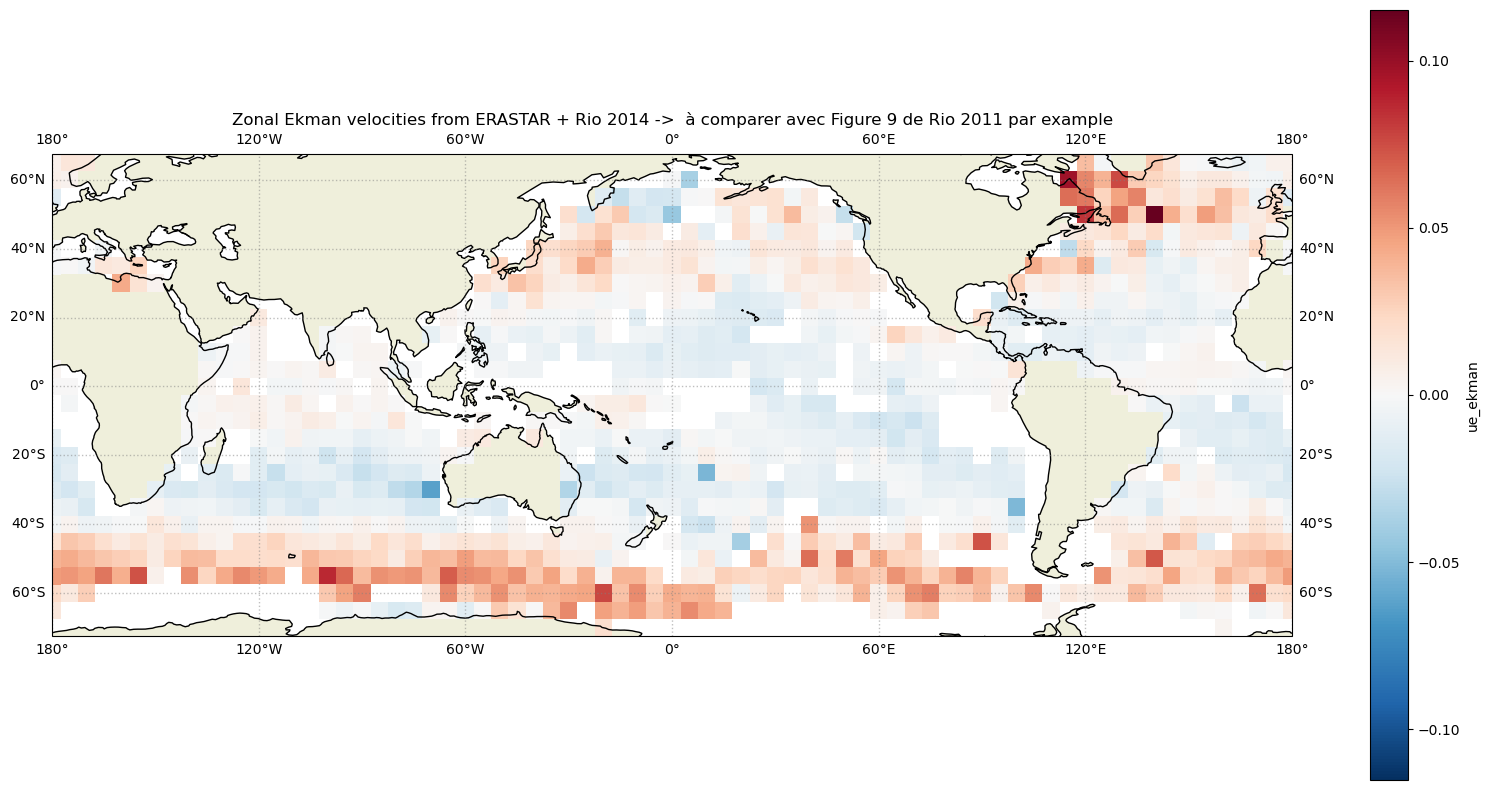

In [60]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(180))
dsl.ue_ekman.plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(180), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
ax.set_title('Zonal Ekman velocities from ERASTAR + Rio 2014 ->  à comparer avec Figure 9 de Rio 2011 par example')


Text(0.5, 1.0, ' Meridional Ekman velocities from ERASTAR + Rio 2014 ->  à comparer avec Figure 9 de Rio 2011 par example')

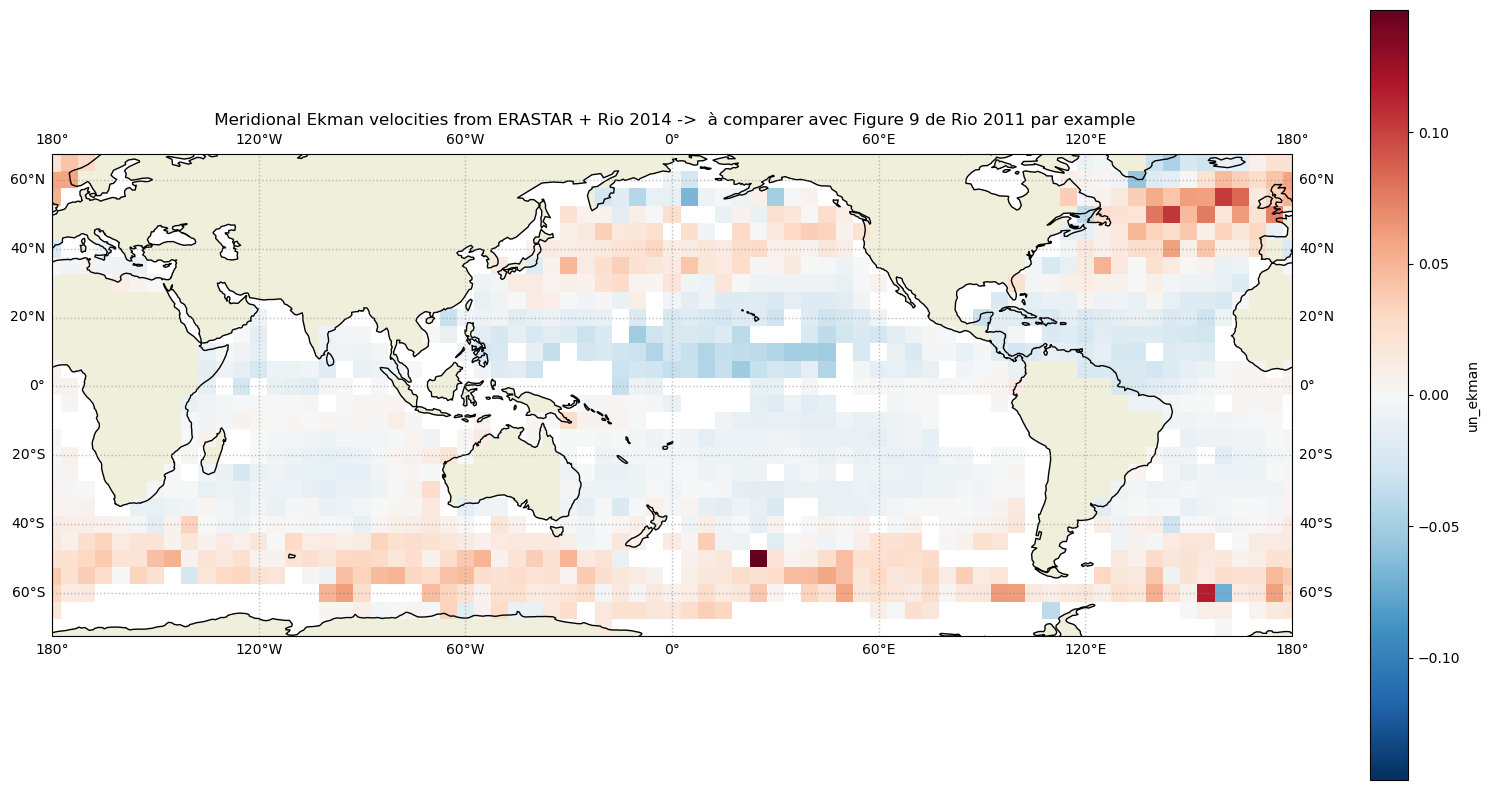

In [59]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(180))
dsl.un_ekman.plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(180), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
ax.set_title(' Meridional Ekman velocities from ERASTAR + Rio 2014 ->  à comparer avec Figure 9 de Rio 2011 par example')


Text(0.5, 1.0, 'Ekman velocities from ERASTAR + Rio 2014 ->  à comparer avec Figure 15 de Rio 2003 par example')

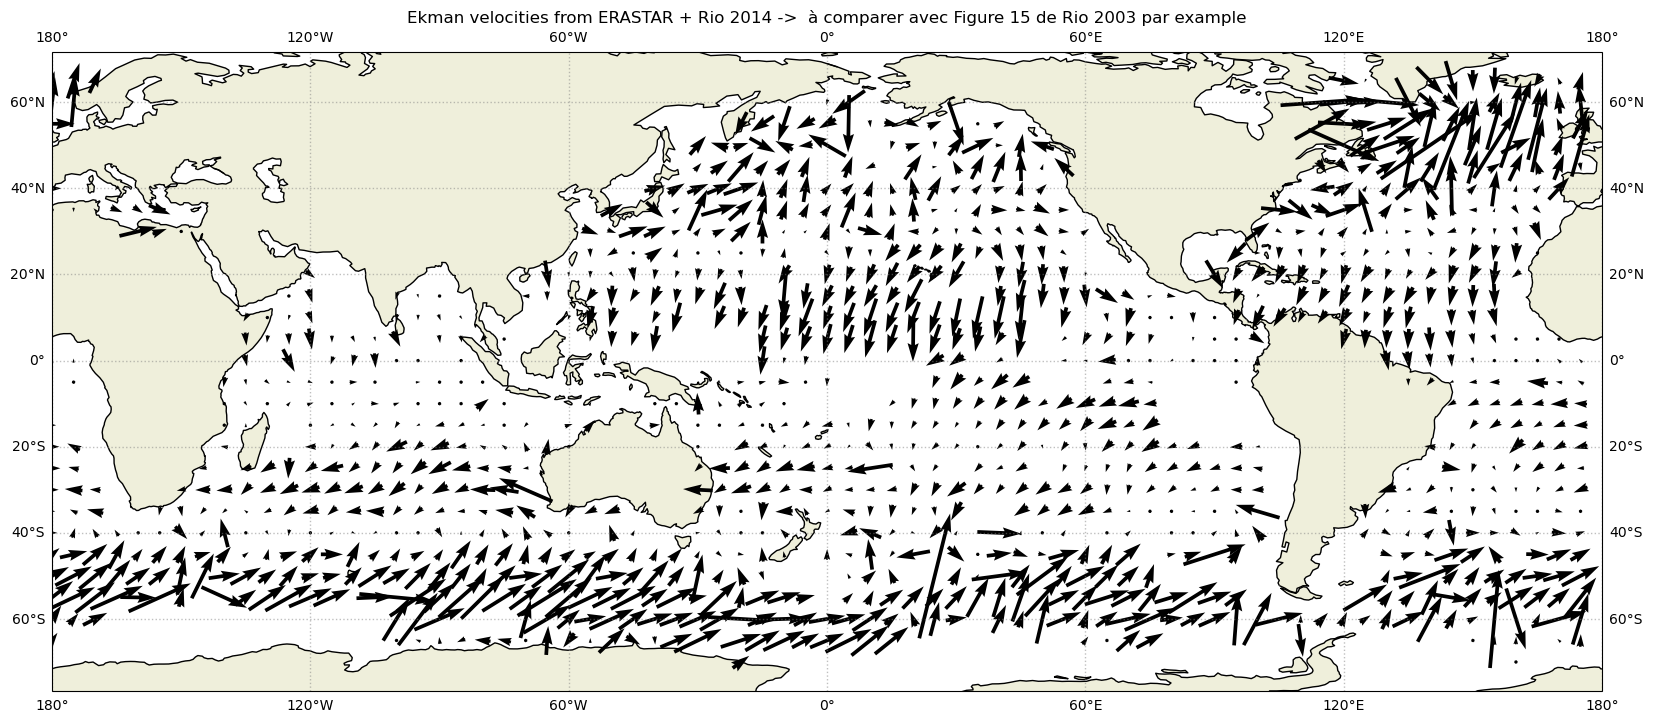

In [56]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(180))
dsl.plot.quiver(x='lonbin', y='latbin', ax=ax,u = 'ue_ekman', v='un_ekman', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(180), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
ax.set_title('Ekman velocities from ERASTAR + Rio 2014 ->  à comparer avec Figure 15 de Rio 2003 par example')


Text(0.5, 1.0, 'Acceleration liées au vent des colocalisations')

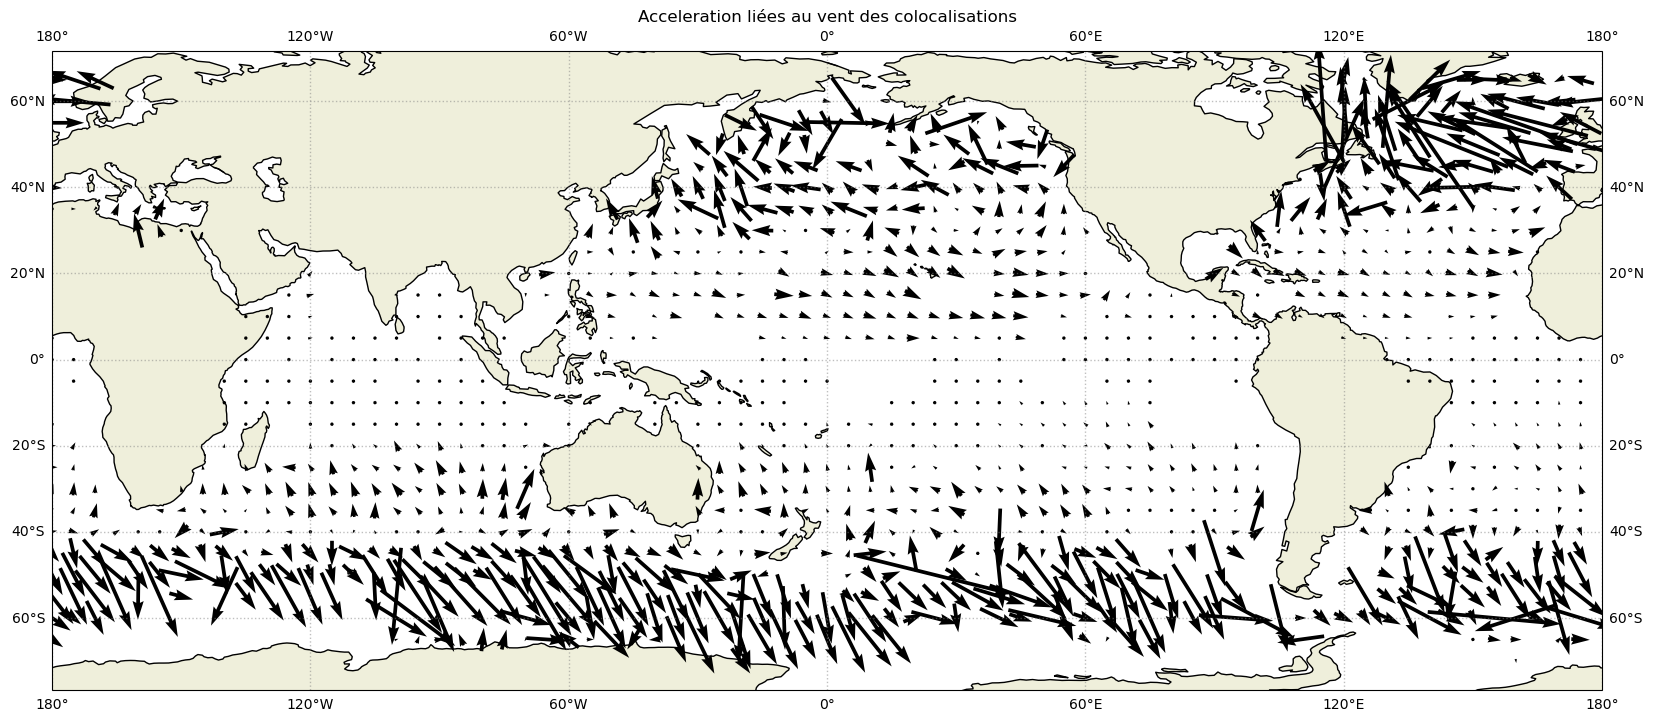

In [57]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(180))
dsl.plot.quiver(x='lonbin', y='latbin', ax=ax,u = 'es_cstrio_z15_alti_wd_e', v='es_cstrio_z15_alti_wd_n', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(180), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

ax.set_title('Acceleration liées au vent des colocalisations')

In [11]:
cluster.close()
